# Drugi Projekat — Nenadgledano učenje
## Tema: Customer Personality Analysis - Klasterizacija kupaca

---
### Autori: Aleksandar Pešić, Mladen Nikolić

---
### Problem koji rešavamo:
```
Segmentacija kupaca na osnovu demografskih karakteristika, ponašanja pri kupovini 
i odgovora na marketing kampanje radi personalizacije marketing strategija.
```

## 1. IMPORT BIBLIOTEKA I UČITAVANJE PODATAKA

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Biblioteke za klasterizaciju
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Metrike za evaluaciju
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

# Outlier detekcija
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

# Konfiguracija prikaza
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

## 2. UČITAVANJE SKUPA PODATAKA

---

In [2]:
# Učitavanje podataka
DATA_PATH = 'marketing_campaign.csv'

df = pd.read_csv(DATA_PATH, sep='\t')

print("\n" + "="*80)
print("OSNOVNE INFORMACIJE O PODACIMA")
print("="*80)
print(f"Dimenzije: {df.shape}")
print(f"Broj transakcija: {len(df):,}")
print(f"Broj features: {df.shape[1]}")

print("\nPrvih 5 redova:")
print(df.head())


OSNOVNE INFORMACIJE O PODACIMA
Dimenzije: (2240, 29)
Broj transakcija: 2,240
Broj features: 29

Prvih 5 redova:
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   
3  10-02-2014       26        11          4               20               10   
4  19-01-2014

## OPIS SKUPA PODATAKA

Na osnovu Kaggle dokumentacije, kolone u `marketing_campaign.csv` predstavljaju:

### People (Demografski podaci)
* **ID**: Jedinstveni identifikator kupca
* **Year_Birth**: Godina rođenja kupca
* **Education**: Nivo obrazovanja kupca
* **Marital_Status**: Bračni status kupca
* **Income**: Godišnji prihod domaćinstva kupca
* **Kidhome**: Broj male dece u domaćinstvu
* **Teenhome**: Broj tinejdžera u domaćinstvu
* **Dt_Customer**: Datum upisa kupca u kompaniju
* **Recency**: Broj dana od poslednje kupovine
* **Complain**: 1 ako se kupac žalio u poslednje 2 godine, 0 ako nije

### Products (Potrošnja)
* **MntWines**: Iznos potrošen na vino u poslednje 2 godine
* **MntFruits**: Iznos potrošen na voće u poslednje 2 godine
* **MntMeatProducts**: Iznos potrošen na meso u poslednje 2 godine
* **MntFishProducts**: Iznos potrošen na ribu u poslednje 2 godine
* **MntSweetProducts**: Iznos potrošen na slatkiše u poslednje 2 godine
* **MntGoldProds**: Iznos potrošen na zlatne proizvode u poslednje 2 godine

### Promotion (Marketing)
* **NumDealsPurchases**: Broj kupovina obavljenih sa popustom
* **AcceptedCmp1**: 1 ako je kupac prihvatio ponudu u 1. kampanji, 0 inače
* **AcceptedCmp2**: 1 ako je kupac prihvatio ponudu u 2. kampanji, 0 inače
* **AcceptedCmp3**: 1 ako je kupac prihvatio ponudu u 3. kampanji, 0 inače
* **AcceptedCmp4**: 1 ako je kupac prihvatio ponudu u 4. kampanji, 0 inače
* **AcceptedCmp5**: 1 ako je kupac prihvatio ponudu u 5. kampanji, 0 inače
* **Response**: 1 ako je kupac prihvatio ponudu u poslednjoj kampanji, 0 inače

### Place (Kanali kupovine)
* **NumWebPurchases**: Broj kupovina obavljenih preko web sajta
* **NumCatalogPurchases**: Broj kupovina obavljenih preko kataloga
* **NumStorePurchases**: Broj kupovina obavljenih direktno u prodavnici
* **NumWebVisitsMonth**: Broj poseta web sajtu u poslednjem mesecu



## 3. PRIPREMA PODATAKA I DESKRIPTIVNA ANALIZA

---

In [3]:
def load_and_explore_data(filepath):
    """
    Učitavanje i osnovna eksploracija podataka.
    """

    df = pd.read_csv(filepath, sep='\t')
    
    print("=" * 80)
    print("OSNOVNA EKSPLORACIJA PODATAKA")
    print("=" * 80)
    print(f"\nDimenzije dataseta: {df.shape}")
    print(f"Broj redova: {df.shape[0]}")
    print(f"Broj kolona: {df.shape[1]}")
    
    print("\n--- Pregled prvih redova ---")
    print(df.head())
    
    print("\n--- Tipovi podataka ---")
    print(df.dtypes)
    
    print("\n--- Statistički pregled ---")
    print(df.describe())
    
    print("\n--- Nedostajuće vrednosti ---")
    missing = df.isnull().sum()
    print(missing[missing > 0])
    
    return df


def feature_engineering(df):
    """
    Kreiranje novih feature-a.
    """

    df = df.copy()
    
    # Obrada datuma
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
    df['Customer_Days'] = (df['Dt_Customer'].max() - df['Dt_Customer']).dt.days
    df['Customer_Years'] = df['Customer_Days'] / 365.25
    
    # Starost
    current_year = df['Dt_Customer'].max().year
    df['Age'] = current_year - df['Year_Birth']
    
    # Ukupna potrošnja
    df['Total_Spent'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + 
                         df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])
    
    # Ukupan broj kupovina
    df['Total_Purchases'] = (df['NumWebPurchases'] + df['NumCatalogPurchases'] + 
                            df['NumStorePurchases'])
    
    # Ukupan broj prihvaćenih kampanja
    df['Total_Accepted_Campaigns'] = (df['AcceptedCmp1'] + df['AcceptedCmp2'] + 
                                      df['AcceptedCmp3'] + df['AcceptedCmp4'] + 
                                      df['AcceptedCmp5'] + df['Response'])
    
    # Broj dece u domaćinstvu
    df['Total_Children'] = df['Kidhome'] + df['Teenhome']
    
    # Bračni status (simplifikacija)
    df['Is_Parent'] = df['Total_Children'].apply(lambda x: 1 if x > 0 else 0)
    
    # Kategorije prihoda (za kasnije analize)
    df['Income_Category'] = pd.qcut(df['Income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Prosečna vrednost kupovine
    df['Avg_Purchase_Value'] = df['Total_Spent'] / (df['Total_Purchases'] + 1)
    
    # Engagement score
    df['Engagement_Score'] = (df['NumWebVisitsMonth'] + df['Total_Purchases'] + 
                             df['Total_Accepted_Campaigns'])
    
    return df


def clean_data(df):
    """
    Čišćenje podataka.
    """

    df = df.copy()
    
    print("\n" + "=" * 80)
    print("ČIŠĆENJE PODATAKA")
    print("=" * 80)
    
    # Obrada nedostajućih vrednosti u Income
    print(f"\nNedostajuće vrednosti u Income: {df['Income'].isnull().sum()}")
    df['Income'].fillna(df['Income'].median(), inplace=True)
    
    # Uklanjanje outlier-a uAge (nerealne vrednosti)
    age_outliers = (df['Age'] < 18) | (df['Age'] > 100)
    print(f"Broj outlier-a u Age: {age_outliers.sum()}")
    df = df[~age_outliers].copy()
    
    # Uklanjanje ekstremnih outlier-a u Income
    income_q1 = df['Income'].quantile(0.01)
    income_q99 = df['Income'].quantile(0.99)
    income_outliers = (df['Income'] < income_q1) | (df['Income'] > income_q99)
    print(f"Broj ekstremnih outlier-a u Income: {income_outliers.sum()}")
    df = df[~income_outliers].copy()
    
    print(f"\nDimenzije nakon čišćenja: {df.shape}")
    
    return df


def visualize_data(df):
    """
    Vizualizacija podataka.
    """
    
    print("\n" + "=" * 80)
    print("VIZUALIZACIJA PODATAKA")
    print("=" * 80)
    
    # Distribucije numeričkih promenljivih
    numerical_cols = ['Age', 'Income', 'Total_Spent', 'Total_Purchases', 
                     'Customer_Years', 'Total_Children']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Distribucija: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frekvencija')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('distribucije.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Korelaciona matrica
    correlation_features = ['Age', 'Income', 'Total_Spent', 'Total_Purchases', 
                           'Customer_Years', 'Total_Children', 'Total_Accepted_Campaigns',
                           'NumWebVisitsMonth', 'Engagement_Score']
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[correlation_features].corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1)
    plt.title('Korelaciona matrica ključnih feature-a', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('korelacija.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Scatterplot: Income vs Total_Spent
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Income'], df['Total_Spent'], alpha=0.5, s=30)
    plt.xlabel('Prihod', fontsize=12)
    plt.ylabel('Ukupna potrošnja', fontsize=12)
    plt.title('Odnos prihoda i potrošnje', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('income_vs_spent.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. OUTLIER DETEKCIJA I OBRADA

---

In [4]:
def detect_outliers(df, features):
    """
    Detekcija outlier-a korišćenjem više metoda.
    """

    print("\n" + "=" * 80)
    print("DETEKCIJA OUTLIER-A")
    print("=" * 80)
    
    X = df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(X_scaled)
    
    # 2. Local Outlier Factor
    lof = LocalOutlierFactor(contamination=0.1)
    outliers_lof = lof.fit_predict(X_scaled)
    
    # 3. Elliptic Envelope
    elliptic = EllipticEnvelope(contamination=0.1, random_state=42)
    outliers_elliptic = elliptic.fit_predict(X_scaled)
    
    # Kombinovani pristup: outlier ako je označen od strane barem 2 metode
    outlier_votes = (outliers_iso == -1).astype(int) + \
                    (outliers_lof == -1).astype(int) + \
                    (outliers_elliptic == -1).astype(int)
    
    df['Is_Outlier'] = (outlier_votes >= 2).astype(int)
    
    print(f"\nIsolation Forest outliers: {(outliers_iso == -1).sum()}")
    print(f"Local Outlier Factor outliers: {(outliers_lof == -1).sum()}")
    print(f"Elliptic Envelope outliers: {(outliers_elliptic == -1).sum()}")
    print(f"Konsenzus outliers (≥2 metode): {df['Is_Outlier'].sum()}")
    
    # Vizualizacija outlier-a
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    methods = [
        ('Isolation Forest', outliers_iso),
        ('Local Outlier Factor', outliers_lof),
        ('Elliptic Envelope', outliers_elliptic)
    ]
    
    for idx, (method_name, predictions) in enumerate(methods):
        axes[idx].scatter(X_scaled[:, 0], X_scaled[:, 1], 
                         c=predictions, cmap='coolwarm', alpha=0.6, s=20)
        axes[idx].set_title(f'{method_name}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('PC1 (standardizovano)')
        axes[idx].set_ylabel('PC2 (standardizovano)')
    
    plt.tight_layout()
    plt.savefig('outlier_detection.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df


def handle_outliers(df, strategy='remove'):
    """
    Obrada outlier-a.
    """

    print("\n" + "=" * 80)
    print(f"OBRADA OUTLIER-A - Strategija: {strategy}")
    print("=" * 80)
    
    if strategy == 'remove':
        df_clean = df[df['Is_Outlier'] == 0].copy()
        print(f"\nUklonjeno redova: {df.shape[0] - df_clean.shape[0]}")
        print(f"Preostalo redova: {df_clean.shape[0]}")
        return df_clean
    
    elif strategy == 'cap':
        # Capping na 1. i 99. percentilu
        df_capped = df.copy()
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        
        for col in numerical_cols:
            if col not in ['Is_Outlier', 'ID']:
                lower = df[col].quantile(0.01)
                upper = df[col].quantile(0.99)
                df_capped[col] = df_capped[col].clip(lower, upper)
        
        print(f"\nPrimenjeno capping na numerical features")
        return df_capped
    
    else:  # keep
        print(f"\nOutlier-i zadržani u datasetu")
        return df

## 5. REDUKCIJA DIMENZIONALNOSTI

---

In [5]:
def apply_pca(X_scaled, n_components=None):
    """
    PCA analiza.
    """

    print("\n" + "=" * 80)
    print("PCA - PRINCIPAL COMPONENT ANALYSIS")
    print("=" * 80)
    
    # PCA sa svim komponentama za analizu
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    # Objašnjena varijansa
    explained_var = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    print(f"\nPrvih 5 komponenti objašnjava: {cumulative_var[4]:.2%} varijanse")
    print(f"Prvih 10 komponenti objašnjava: {cumulative_var[9]:.2%} varijanse")
    
    # Vizualizacija
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Scree plot
    axes[0].plot(range(1, len(explained_var) + 1), explained_var, 'bo-')
    axes[0].set_xlabel('Broj komponente', fontsize=12)
    axes[0].set_ylabel('Objašnjena varijansa', fontsize=12)
    axes[0].set_title('Scree Plot - Objašnjena varijansa po komponenti', 
                     fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Kumulativna objašnjena varijansa
    axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'ro-')
    axes[1].axhline(y=0.90, color='g', linestyle='--', label='90% varijanse')
    axes[1].axhline(y=0.95, color='b', linestyle='--', label='95% varijanse')
    axes[1].set_xlabel('Broj komponenti', fontsize=12)
    axes[1].set_ylabel('Kumulativna objašnjena varijansa', fontsize=12)
    axes[1].set_title('Kumulativna objašnjena varijansa', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Odabir broja komponenti
    if n_components is None:
        # Biramo broj komponenti koji objašnjava 90% varijanse
        n_components = np.argmax(cumulative_var >= 0.90) + 1
        print(f"\nOdabrano {n_components} komponenti (objašnjava ≥90% varijanse)")
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    return X_pca, pca


def apply_tsne(X_scaled, n_components=2, perplexity=30):
    """
    t-SNE analiza.
    """

    print("\n" + "=" * 80)
    print("t-SNE - t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING")
    print("=" * 80)
    
    tsne = TSNE(n_components=n_components, perplexity=perplexity, 
                random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_scaled)
    
    print(f"\nKreirana {n_components}D t-SNE reprezentacija")
    print(f"Perplexity: {perplexity}")
    
    return X_tsne

## 6. KLASTERIZACIJA - RAZLIČITI ALGORITMI

---

In [6]:
def determine_optimal_k_kmeans(X, max_k=10):
    """
    Određivanje optimalnog broja klastera za K-Means.
    """

    print("\n" + "=" * 80)
    print("ODREĐIVANJE OPTIMALNOG BROJA KLASTERA")
    print("=" * 80)
    
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    davies_bouldin_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        calinski_scores.append(calinski_harabasz_score(X, labels))
        davies_bouldin_scores.append(davies_bouldin_score(X, labels))
    
    # Vizualizacija
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Elbow method
    axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2)
    axes[0, 0].set_xlabel('Broj klastera (k)', fontsize=12)
    axes[0, 0].set_ylabel('Inertia', fontsize=12)
    axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Silhouette score (veći je bolji)
    axes[0, 1].plot(k_range, silhouette_scores, 'go-', linewidth=2)
    axes[0, 1].set_xlabel('Broj klastera (k)', fontsize=12)
    axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
    axes[0, 1].set_title('Silhouette Score (veći = bolji)', fontsize=12, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Calinski-Harabasz score (veći je bolji)
    axes[1, 0].plot(k_range, calinski_scores, 'ro-', linewidth=2)
    axes[1, 0].set_xlabel('Broj klastera (k)', fontsize=12)
    axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
    axes[1, 0].set_title('Calinski-Harabasz Score (veći = bolji)', fontsize=12, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Davies-Bouldin score (manji je bolji)
    axes[1, 1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2)
    axes[1, 1].set_xlabel('Broj klastera (k)', fontsize=12)
    axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
    axes[1, 1].set_title('Davies-Bouldin Score (manji = bolji)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('optimal_k_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Preporuka
    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    optimal_k_calinski = k_range[np.argmax(calinski_scores)]
    optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
    
    print(f"\nPreporučeni broj klastera:")
    print(f"  - Po Silhouette Score: k = {optimal_k_silhouette}")
    print(f"  - Po Calinski-Harabasz: k = {optimal_k_calinski}")
    print(f"  - Po Davies-Bouldin: k = {optimal_k_db}")
    
    return optimal_k_silhouette


def apply_kmeans(X, n_clusters):
    """
    K-Means klasterizacija.
    """

    print("\n" + "=" * 80)
    print(f"K-MEANS KLASTERIZACIJA (k={n_clusters})")
    print("=" * 80)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Evaluacija
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    print(f"\nMetrike kvaliteta:")
    print(f"  - Silhouette Score: {silhouette:.4f}")
    print(f"  - Calinski-Harabasz Score: {calinski:.4f}")
    print(f"  - Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  - Inertia: {kmeans.inertia_:.4f}")
    
    return labels, kmeans, {
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'inertia': kmeans.inertia_
    }


def apply_hierarchical(X, n_clusters, linkage_method='ward'):
    """
    Hijerarhijska klasterizacija.
    """

    print("\n" + "=" * 80)
    print(f"HIJERARHIJSKA KLASTERIZACIJA (linkage={linkage_method})")
    print("=" * 80)
    
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    labels = hierarchical.fit_predict(X)
    
    # Evaluacija
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    
    print(f"\nMetrike kvaliteta:")
    print(f"  - Silhouette Score: {silhouette:.4f}")
    print(f"  - Calinski-Harabasz Score: {calinski:.4f}")
    print(f"  - Davies-Bouldin Score: {davies_bouldin:.4f}")
    
    # Dendrogram (samo za manji uzorak)
    if X.shape[0] <= 100:
        plt.figure(figsize=(12, 6))
        Z = linkage(X, method=linkage_method)
        dendrogram(Z)
        plt.title(f'Dendrogram - {linkage_method} linkage', fontsize=14, fontweight='bold')
        plt.xlabel('Indeks uzorka')
        plt.ylabel('Rastojanje')
        plt.tight_layout()
        plt.savefig(f'dendrogram_{linkage_method}.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return labels, hierarchical, {
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin
    }


def apply_dbscan(X, eps=0.5, min_samples=5):
    """
    DBSCAN klasterizacija.
    """

    print("\n" + "=" * 80)
    print(f"DBSCAN KLASTERIZACIJA (eps={eps}, min_samples={min_samples})")
    print("=" * 80)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    print(f"\nPronadjeno klastera: {n_clusters}")
    print(f"Noise tačke: {n_noise} ({n_noise/len(labels)*100:.2f}%)")
    
    # Evaluacija (bez noise tačaka)
    if n_clusters > 1 and n_noise < len(labels):
        mask = labels != -1
        X_no_noise = X[mask]
        labels_no_noise = labels[mask]
        
        silhouette = silhouette_score(X_no_noise, labels_no_noise)
        calinski = calinski_harabasz_score(X_no_noise, labels_no_noise)
        davies_bouldin = davies_bouldin_score(X_no_noise, labels_no_noise)
        
        print(f"\nMetrike kvaliteta (bez noise):")
        print(f"  - Silhouette Score: {silhouette:.4f}")
        print(f"  - Calinski-Harabasz Score: {calinski:.4f}")
        print(f"  - Davies-Bouldin Score: {davies_bouldin:.4f}")
        
        metrics = {
            'silhouette': silhouette,
            'calinski_harabasz': calinski,
            'davies_bouldin': davies_bouldin,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        }
    else:
        print("\nNedovoljno klastera za evaluaciju metrika")
        metrics = {
            'n_clusters': n_clusters,
            'n_noise': n_noise
        }
    
    return labels, dbscan, metrics


def apply_gaussian_mixture(X, n_components):
    """
    Gaussian Mixture Model klasterizacija.
    """

    print("\n" + "=" * 80)
    print(f"GAUSSIAN MIXTURE MODEL (n_components={n_components})")
    print("=" * 80)
    
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    labels = gmm.predict(X)
    
    # Evaluacija
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    bic = gmm.bic(X)
    aic = gmm.aic(X)
    
    print(f"\nMetrike kvaliteta:")
    print(f"  - Silhouette Score: {silhouette:.4f}")
    print(f"  - Calinski-Harabasz Score: {calinski:.4f}")
    print(f"  - Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  - BIC: {bic:.4f}")
    print(f"  - AIC: {aic:.4f}")
    
    return labels, gmm, {
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'bic': bic,
        'aic': aic
    }


## 7. VIZUALIZACIJA I POREĐENJE REZULTATA

---

In [7]:
def visualize_clusters(X_2d, labels_dict, method_names):
    """
    Vizualizacija klastera u 2D prostoru.
    """

    n_methods = len(labels_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(6 * n_methods, 5))
    
    if n_methods == 1:
        axes = [axes]
    
    for idx, (method, labels) in enumerate(labels_dict.items()):
        scatter = axes[idx].scatter(X_2d[:, 0], X_2d[:, 1], 
                                   c=labels, cmap='tab10', 
                                   alpha=0.6, s=30, edgecolors='k', linewidth=0.5)
        axes[idx].set_title(f'{method_names[method]}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Dimenzija 1')
        axes[idx].set_ylabel('Dimenzija 2')
        axes[idx].grid(True, alpha=0.3)
        
        # Dodaj colorbar
        plt.colorbar(scatter, ax=axes[idx], label='Klaster')
    
    plt.tight_layout()
    plt.savefig('cluster_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def compare_clustering_methods(metrics_dict):
    """
    Uporedna tabela metrika za različite metode.
    """

    print("\n" + "=" * 80)
    print("UPOREDNA ANALIZA METODA KLASTERIZACIJE")
    print("=" * 80)
    
    # Kreiranje DataFrame-a
    comparison_data = []
    for method, metrics in metrics_dict.items():
        row = {'Metoda': method}
        row.update(metrics)
        comparison_data.append(row)
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Formatiranje
    if 'silhouette' in df_comparison.columns:
        df_comparison = df_comparison.sort_values('silhouette', ascending=False)
    
    print("\n")
    print(df_comparison.to_string(index=False))
    
    # Vizualizacija metrika
    if 'silhouette' in df_comparison.columns:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Silhouette Score
        axes[0].barh(df_comparison['Metoda'], df_comparison['silhouette'], color='skyblue')
        axes[0].set_xlabel('Silhouette Score', fontsize=12)
        axes[0].set_title('Silhouette Score (veći = bolji)', fontsize=12, fontweight='bold')
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # Calinski-Harabasz Score
        if 'calinski_harabasz' in df_comparison.columns:
            axes[1].barh(df_comparison['Metoda'], df_comparison['calinski_harabasz'], color='lightgreen')
            axes[1].set_xlabel('Calinski-Harabasz Score', fontsize=12)
            axes[1].set_title('Calinski-Harabasz Score (veći = bolji)', fontsize=12, fontweight='bold')
            axes[1].grid(True, alpha=0.3, axis='x')
        
        # Davies-Bouldin Score
        if 'davies_bouldin' in df_comparison.columns:
            axes[2].barh(df_comparison['Metoda'], df_comparison['davies_bouldin'], color='lightcoral')
            axes[2].set_xlabel('Davies-Bouldin Score', fontsize=12)
            axes[2].set_title('Davies-Bouldin Score (manji = bolji)', fontsize=12, fontweight='bold')
            axes[2].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return df_comparison

## 8. ANALIZA KLASTERA I PROFILISANJE

---

In [8]:
def analyze_clusters(df, labels, feature_cols):
    """
    Detaljna analiza karakteristika klastera.
    """

    print("\n" + "=" * 80)
    print("ANALIZA I PROFILISANJE KLASTERA")
    print("=" * 80)
    
    df_analysis = df.copy()
    df_analysis['Cluster'] = labels
    
    # Osnovne statistike po klasterima
    print("\n--- Veličina klastera ---")
    cluster_sizes = df_analysis['Cluster'].value_counts().sort_index()
    print(cluster_sizes)
    print(f"\nProcenat uzoraka po klasterima:")
    print((cluster_sizes / len(df_analysis) * 100).round(2))
    
    # Srednje vrednosti po klasterima
    print("\n--- Prosečne vrednosti karakteristika po klasterima ---")
    cluster_profiles = df_analysis.groupby('Cluster')[feature_cols].mean()
    print(cluster_profiles.round(2))
    
    # Vizualizacija profila klastera
    n_features = len(feature_cols)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.ravel() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feature in enumerate(feature_cols):
        cluster_means = df_analysis.groupby('Cluster')[feature].mean()
        axes[idx].bar(cluster_means.index, cluster_means.values, color='steelblue', alpha=0.7)
        axes[idx].set_xlabel('Klaster', fontsize=10)
        axes[idx].set_ylabel(f'Prosečna {feature}', fontsize=10)
        axes[idx].set_title(f'{feature} po klasterima', fontsize=11, fontweight='bold')
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Sakrij neiskorišćene subplot-ove
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('cluster_profiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cluster_profiles


def create_cluster_descriptions(df, labels, feature_cols):
    """
    Kreiranje opisnih profila za svaki klaster.
    """

    print("\n" + "=" * 80)
    print("OPISNI PROFILI KLASTERA")
    print("=" * 80)
    
    df_desc = df.copy()
    df_desc['Cluster'] = labels
    
    unique_clusters = sorted(df_desc['Cluster'].unique())
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # DBSCAN noise
            continue
            
        print(f"\n{'=' * 80}")
        print(f"KLASTER {cluster_id}")
        print(f"{'=' * 80}")
        
        cluster_data = df_desc[df_desc['Cluster'] == cluster_id]
        cluster_size = len(cluster_data)
        cluster_pct = (cluster_size / len(df_desc)) * 100
        
        print(f"\nVeličina: {cluster_size} kupaca ({cluster_pct:.1f}% ukupnog)")
        
        print(f"\nKljučne karakteristike:")
        for feature in feature_cols[:8]:  # Top 8 features
            mean_val = cluster_data[feature].mean()
            overall_mean = df_desc[feature].mean()
            diff_pct = ((mean_val - overall_mean) / overall_mean) * 100
            
            if abs(diff_pct) > 10:  # Prikaži samo značajne razlike
                direction = "viša" if diff_pct > 0 else "niža"
                print(f"  - {feature}: {mean_val:.2f} ({direction} {abs(diff_pct):.1f}% od proseka)")

## 9. GLAVNI PIPELINE

---

In [9]:
def main_pipeline():
    """
    Glavni pipeline za analizu.
    """

    print("\n" + "=" * 80)
    print("CUSTOMER PERSONALITY ANALYSIS - KLASTERIZACIJA")
    print("Nenadgledano učenje - Projekat 2")
    print("=" * 80)
    
    # FAZA 1: UČITAVANJE I PRIPREMA 
    df = load_and_explore_data(DATA_PATH)
    df = feature_engineering(df)
    df = clean_data(df)
    visualize_data(df)
    
    # FAZA 2: SELEKCIJA FEATURE-A 
    # Biramo relevantne numeričke feature-e za klasterizaciju
    clustering_features = [
        'Age', 'Income', 'Total_Spent', 'Total_Purchases',
        'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
        'NumWebVisitsMonth', 'Total_Children', 'Customer_Years',
        'Total_Accepted_Campaigns', 'Engagement_Score',
        'MntWines', 'MntFruits', 'MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'
    ]
    
    # FAZA 3: OUTLIER DETEKCIJA I OBRADA
    df = detect_outliers(df, clustering_features)
    df_clean = handle_outliers(df, strategy='remove')  # Možeš probati 'cap' ili 'keep'
    
    # FAZA 4: SKALIRANJE
    X = df_clean[clustering_features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("\n" + "=" * 80)
    print("PODACI SPREMNI ZA KLASTERIZACIJU")
    print("=" * 80)
    print(f"Broj uzoraka: {X_scaled.shape[0]}")
    print(f"Broj feature-a: {X_scaled.shape[1]}")
    
    # FAZA 5: REDUKCIJA DIMENZIONALNOSTI
    X_pca, pca = apply_pca(X_scaled, n_components=None)  # Auto-select
    X_tsne = apply_tsne(X_scaled, n_components=2, perplexity=30)
    
    # Vizualizacija u 2D (PCA)
    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, s=30)
    plt.xlabel('Prva glavna komponenta', fontsize=12)
    plt.ylabel('Druga glavna komponenta', fontsize=12)
    plt.title('PCA - 2D projekcija podataka', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_2d.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # FAZA 6: KLASTERIZACIJA - RAZLIČITI ALGORITMI
    
    # 6.1 Određivanje optimalnog broja klastera
    optimal_k = determine_optimal_k_kmeans(X_pca, max_k=10)
    
    # Koristimo optimalan k (ili manuelno biramo, npr. 4)
    n_clusters = 4
    
    # 6.2 K-Means
    labels_kmeans, model_kmeans, metrics_kmeans = apply_kmeans(X_pca, n_clusters)
    
    # 6.3 Hijerarhijska klasterizacija
    labels_hierarchical, model_hierarchical, metrics_hierarchical = apply_hierarchical(
        X_pca, n_clusters, linkage_method='ward'
    )
    
    # 6.4 DBSCAN
    labels_dbscan, model_dbscan, metrics_dbscan = apply_dbscan(
        X_pca, eps=2.5, min_samples=10
    )
    
    # 6.5 Gaussian Mixture Model
    labels_gmm, model_gmm, metrics_gmm = apply_gaussian_mixture(X_pca, n_clusters)
    
    # FAZA 7: VIZUALIZACIJA I POREĐENJE
    
    # Priprema labela za vizualizaciju
    labels_dict = {
        'K-Means': labels_kmeans,
        'Hierarchical': labels_hierarchical,
        'DBSCAN': labels_dbscan,
        'GMM': labels_gmm
    }
    
    method_names = {
        'K-Means': 'K-Means',
        'Hierarchical': 'Hijerarhijska (Ward)',
        'DBSCAN': 'DBSCAN',
        'GMM': 'Gaussian Mixture'
    }
    
    # Vizualizacija sa PCA
    visualize_clusters(X_pca[:, :2], labels_dict, method_names)
    
    # Vizualizacija sa t-SNE
    visualize_clusters(X_tsne, labels_dict, method_names)
    
    # Uporedna analiza metrika
    metrics_dict = {
        'K-Means': metrics_kmeans,
        'Hierarchical': metrics_hierarchical,
        'GMM': metrics_gmm
    }
    
    if metrics_dbscan.get('silhouette'):
        metrics_dict['DBSCAN'] = metrics_dbscan
    
    df_comparison = compare_clustering_methods(metrics_dict)
    
    # FAZA 8: DETALJNA ANALIZA NAJBOLJE METODE
    
    # Biramo metodu sa najboljim Silhouette Score-om
    best_method = df_comparison.iloc[0]['Metoda']
    best_labels = labels_dict[best_method]
    
    print("\n" + "=" * 80)
    print(f"DETALJNA ANALIZA - NAJBOLJA METODA: {best_method}")
    print("=" * 80)
    
    # Analiza klastera
    cluster_profiles = analyze_clusters(df_clean, best_labels, clustering_features)
    create_cluster_descriptions(df_clean, best_labels, clustering_features)
    
    # Dodatna vizualizacija - Box plots
    df_clean['Cluster'] = best_labels
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    key_features = ['Age', 'Income', 'Total_Spent', 'Total_Purchases', 
                   'Total_Accepted_Campaigns', 'Engagement_Score']
    
    for idx, feature in enumerate(key_features):
        df_clean.boxplot(column=feature, by='Cluster', ax=axes[idx])
        axes[idx].set_title(f'{feature} po klasterima', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel('Klaster')
        axes[idx].set_ylabel(feature)
        plt.sca(axes[idx])
        plt.xticks(rotation=0)
    
    plt.suptitle('')  # Ukloni automatski naslov
    plt.tight_layout()
    plt.savefig('boxplots_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # FAZA 9: BUSINESS INSIGHTS
    print("\n" + "=" * 80)
    print("BUSINESS INSIGHTS I PREPORUKE")
    print("=" * 80)
    
    for cluster_id in sorted(df_clean['Cluster'].unique()):
        if cluster_id == -1:
            continue
        
        cluster_data = df_clean[df_clean['Cluster'] == cluster_id]
        
        avg_income = cluster_data['Income'].mean()
        avg_spent = cluster_data['Total_Spent'].mean()
        avg_campaigns = cluster_data['Total_Accepted_Campaigns'].mean()
        avg_age = cluster_data['Age'].mean()
        
        print(f"\n--- Klaster {cluster_id} ---")
        print(f"Prosečan prihod: ${avg_income:,.0f}")
        print(f"Prosečna potrošnja: ${avg_spent:,.0f}")
        print(f"Prosečan broj prihvaćenih kampanja: {avg_campaigns:.2f}")
        print(f"Prosečna starost: {avg_age:.1f} godina")
        
        # Preporuke na osnovu profila
        if avg_spent > df_clean['Total_Spent'].median() and avg_campaigns > df_clean['Total_Accepted_Campaigns'].median():
            print("Preporuka: Premium kupci - fokusirajte se na loyalty programe i ekskluzivne ponude")
        elif avg_spent < df_clean['Total_Spent'].median() and avg_campaigns < df_clean['Total_Accepted_Campaigns'].median():
            print("Preporuka: Neangažovani kupci - potrebne su agresivnije marketing kampanje i popusti")
        elif avg_income > df_clean['Income'].median() and avg_spent < df_clean['Total_Spent'].median():
            print("Preporuka: Potencijalni kupci sa visokim prihodima - targetirajte premium proizvode")

    # ZAVRŠNA STATISTIKA
    print("\n" + "=" * 80)
    print("REZIME PROJEKTA")
    print("=" * 80)
    print(f"\nBroj analiziranih kupaca: {len(df_clean)}")
    print(f"Broj korišćenih feature-a: {len(clustering_features)}")
    print(f"Broj PCA komponenti: {X_pca.shape[1]}")
    print(f"Najbolja metoda klasterizacije: {best_method}")
    print(f"Broj identifikovanih segmenata: {len(set(best_labels)) - (1 if -1 in best_labels else 0)}")
    print(f"Silhouette Score: {metrics_dict[best_method]['silhouette']:.4f}")
    
    return df_clean, best_labels, cluster_profiles

## 10. POKRETANJE PIPELINE

---


CUSTOMER PERSONALITY ANALYSIS - KLASTERIZACIJA
Nenadgledano učenje - Projekat 2
OSNOVNA EKSPLORACIJA PODATAKA

Dimenzije dataseta: (2240, 29)
Broj redova: 2240
Broj kolona: 29

--- Pregled prvih redova ---
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  04-09-2012       58       635         88              546              172   
1  08-03-2014       38        11          1                6                2   
2  21-08-2013       26       426         49              127              111   


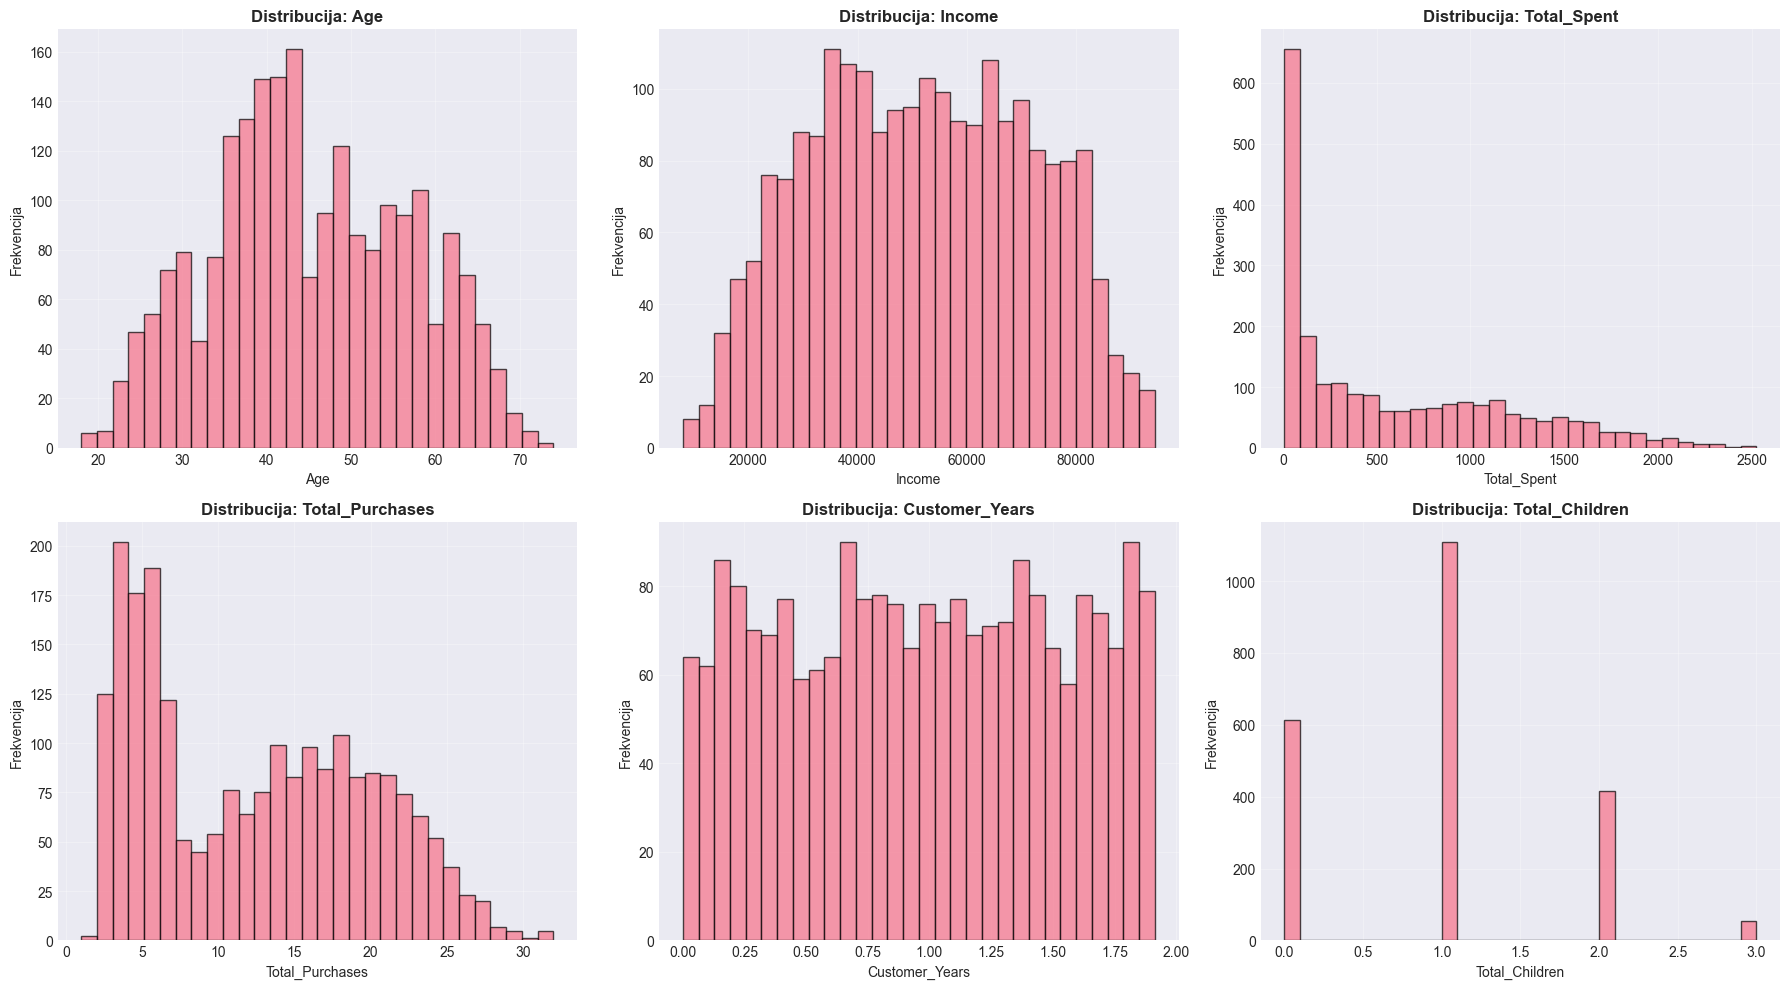

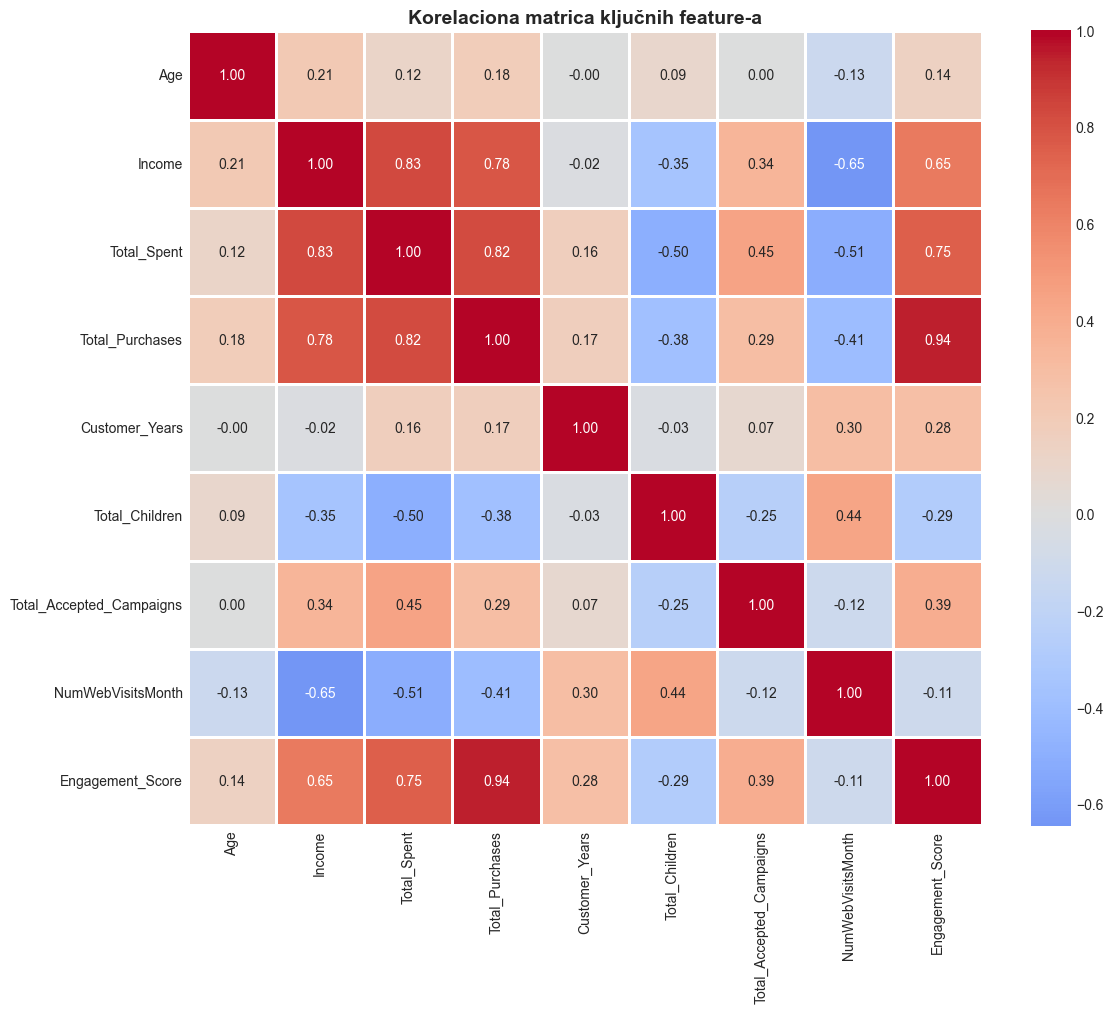

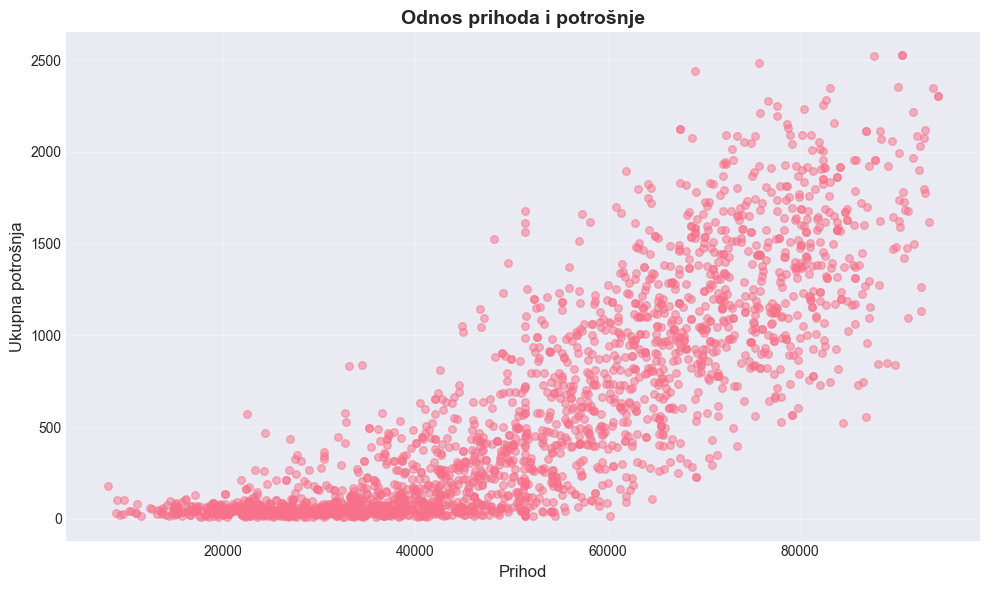


DETEKCIJA OUTLIER-A

Isolation Forest outliers: 219
Local Outlier Factor outliers: 219
Elliptic Envelope outliers: 220
Konsenzus outliers (≥2 metode): 154


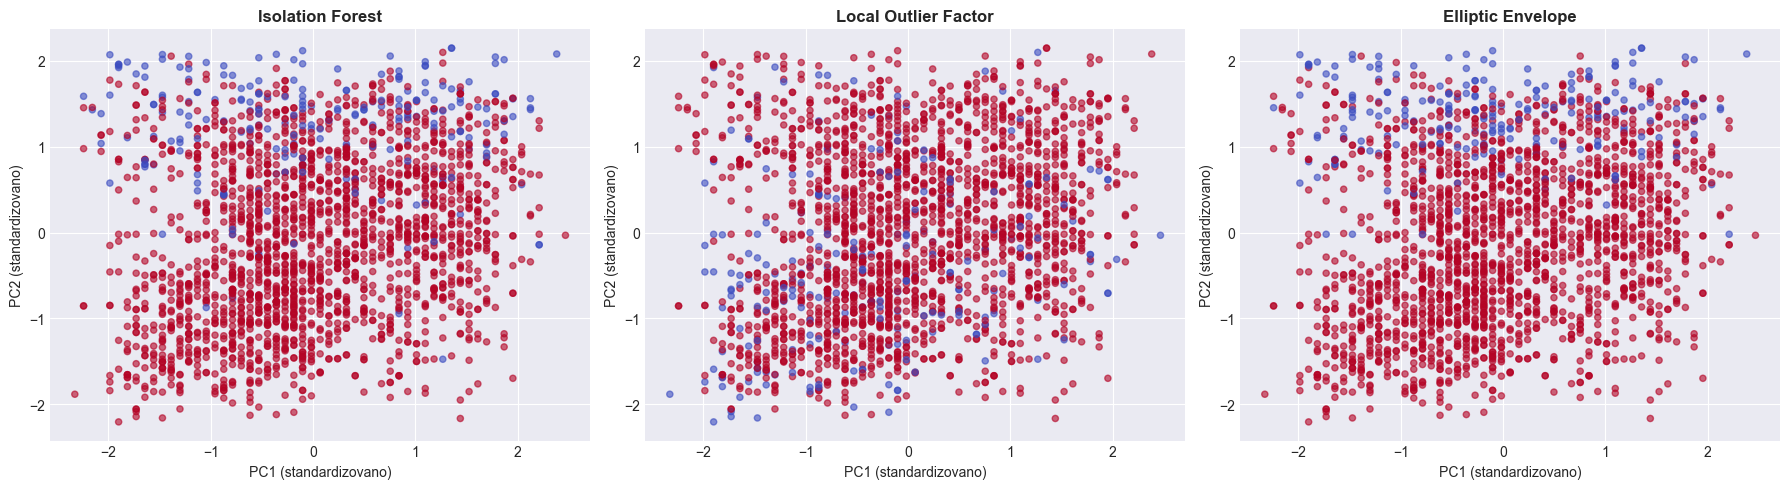


OBRADA OUTLIER-A - Strategija: remove

Uklonjeno redova: 154
Preostalo redova: 2037

PODACI SPREMNI ZA KLASTERIZACIJU
Broj uzoraka: 2037
Broj feature-a: 18

PCA - PRINCIPAL COMPONENT ANALYSIS

Prvih 5 komponenti objašnjava: 77.47% varijanse
Prvih 10 komponenti objašnjava: 92.52% varijanse


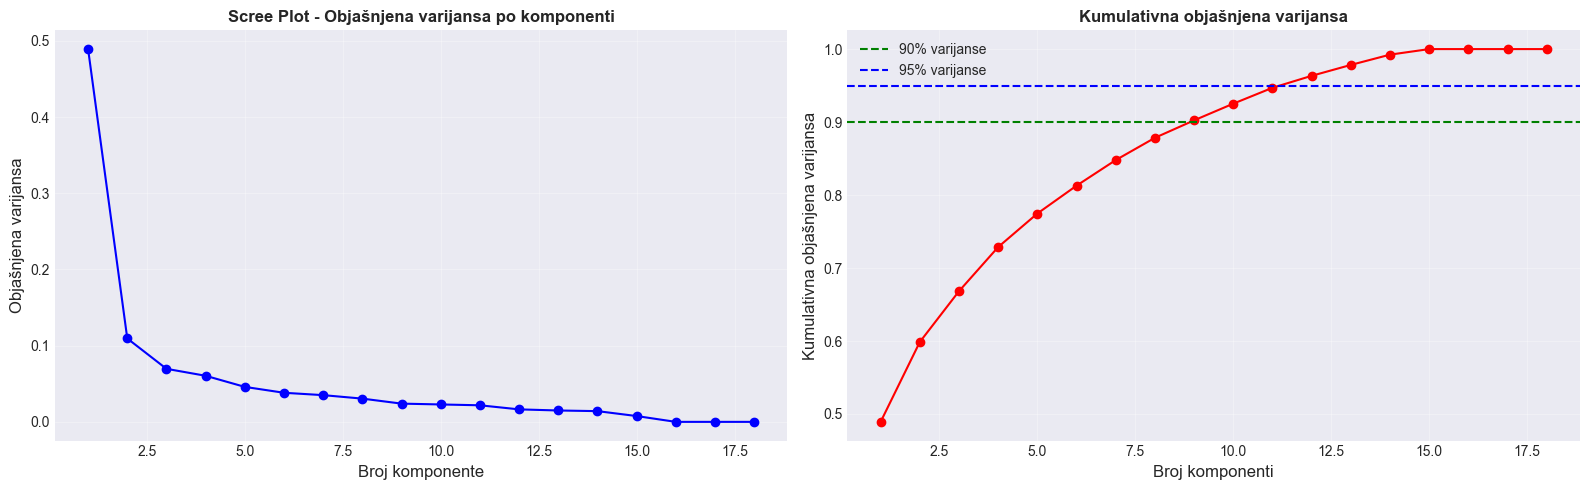


Odabrano 9 komponenti (objašnjava ≥90% varijanse)

t-SNE - t-DISTRIBUTED STOCHASTIC NEIGHBOR EMBEDDING

Kreirana 2D t-SNE reprezentacija
Perplexity: 30


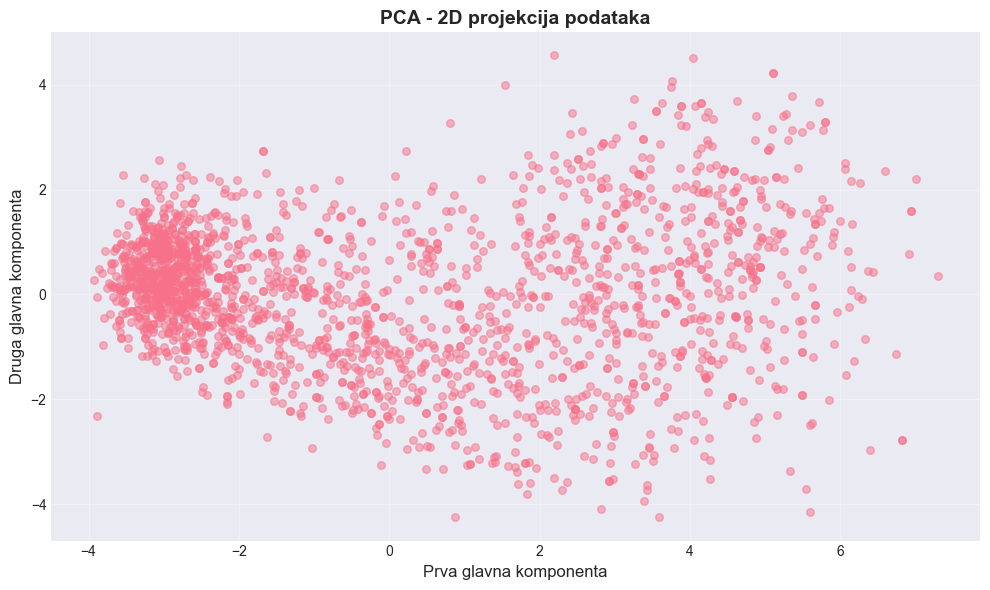


ODREĐIVANJE OPTIMALNOG BROJA KLASTERA


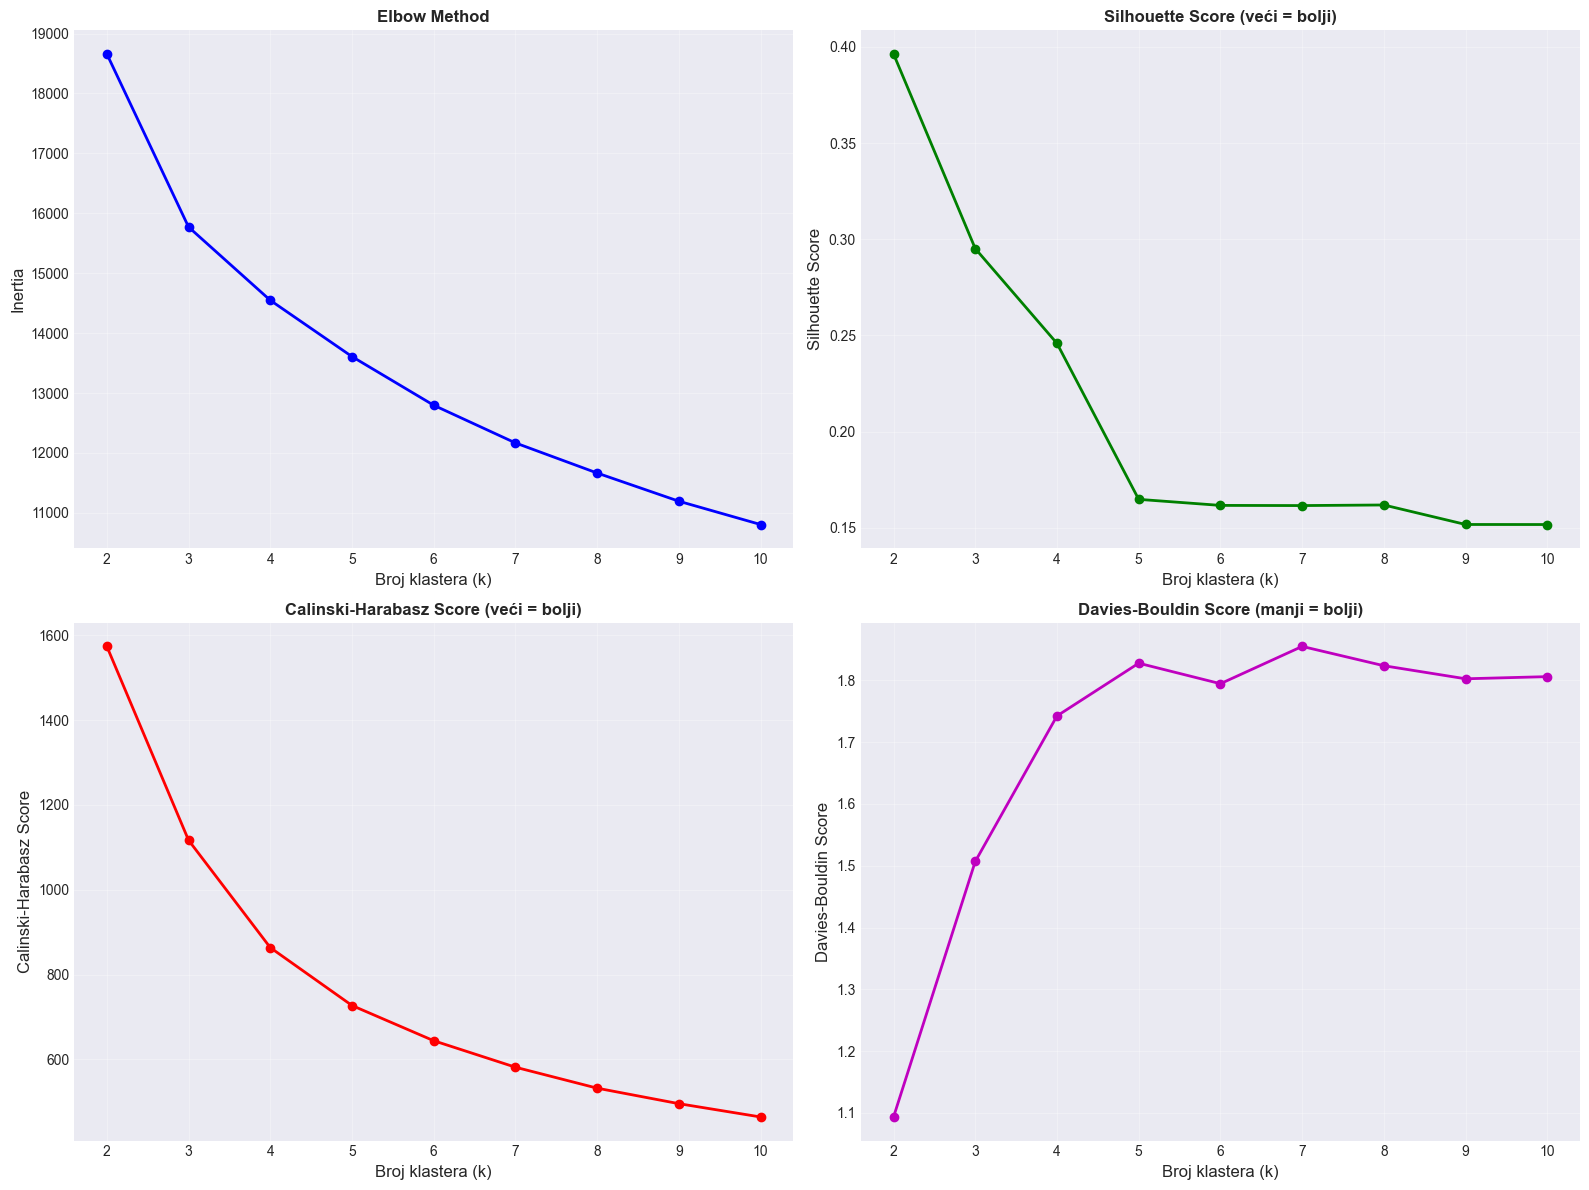


Preporučeni broj klastera:
  - Po Silhouette Score: k = 2
  - Po Calinski-Harabasz: k = 2
  - Po Davies-Bouldin: k = 2

K-MEANS KLASTERIZACIJA (k=4)

Metrike kvaliteta:
  - Silhouette Score: 0.2459
  - Calinski-Harabasz Score: 863.5591
  - Davies-Bouldin Score: 1.7425
  - Inertia: 14547.5689

HIJERARHIJSKA KLASTERIZACIJA (linkage=ward)

Metrike kvaliteta:
  - Silhouette Score: 0.1870
  - Calinski-Harabasz Score: 784.0340
  - Davies-Bouldin Score: 1.8293

DBSCAN KLASTERIZACIJA (eps=2.5, min_samples=10)

Pronadjeno klastera: 1
Noise tačke: 116 (5.69%)

Nedovoljno klastera za evaluaciju metrika

GAUSSIAN MIXTURE MODEL (n_components=4)

Metrike kvaliteta:
  - Silhouette Score: 0.1370
  - Calinski-Harabasz Score: 637.2806
  - Davies-Bouldin Score: 2.3661
  - BIC: 40071.3226
  - AIC: 38840.7105


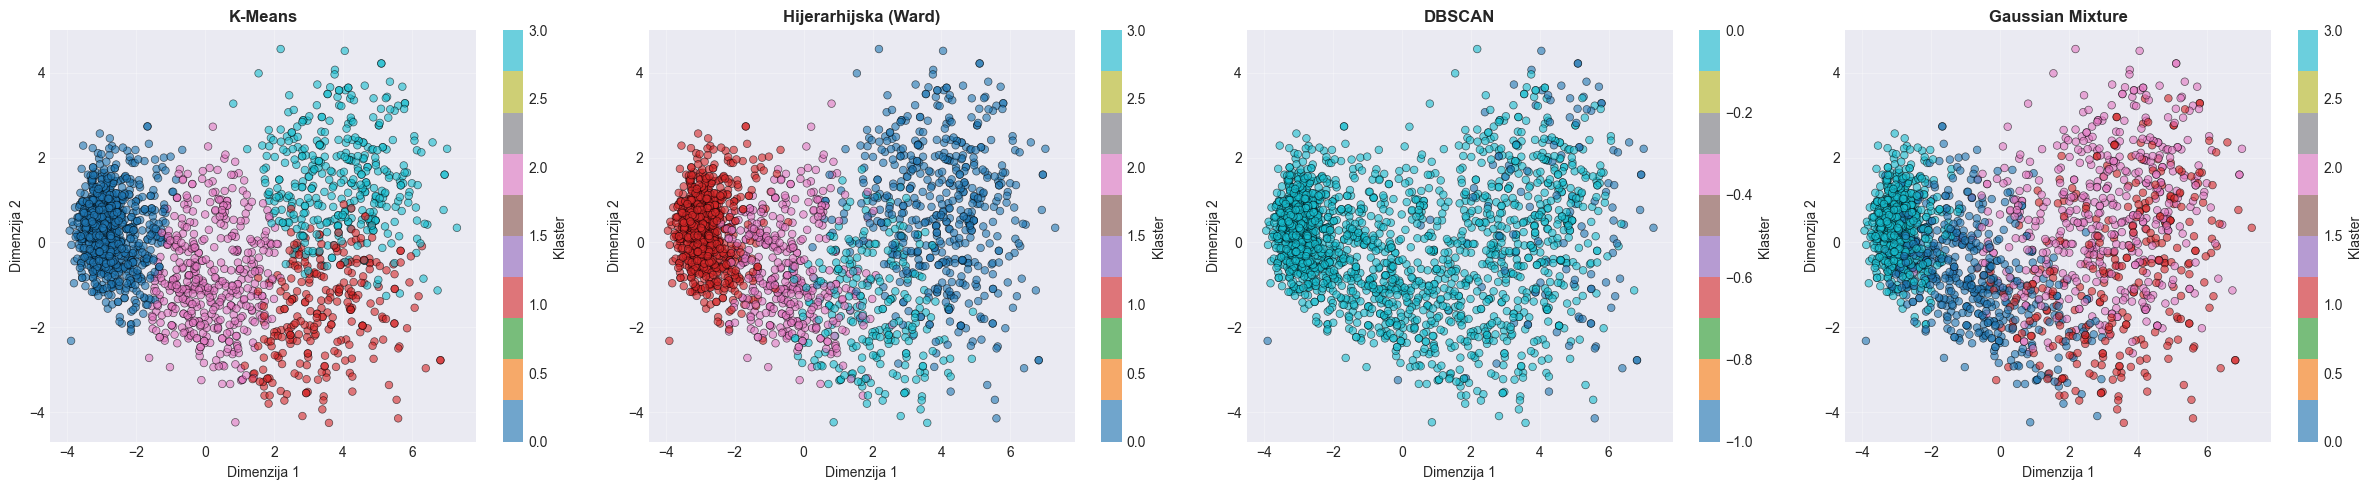

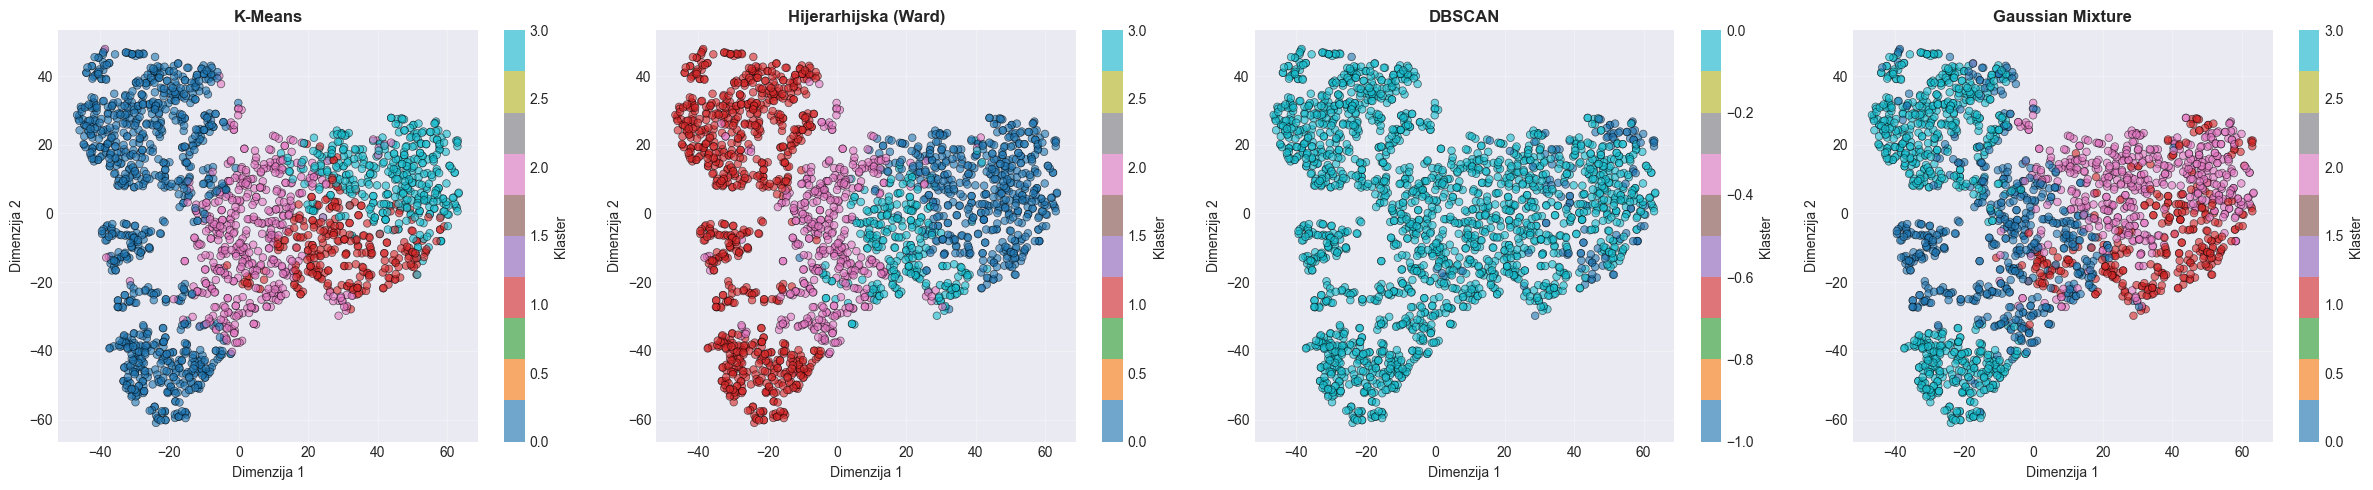


UPOREDNA ANALIZA METODA KLASTERIZACIJE


      Metoda  silhouette  calinski_harabasz  davies_bouldin      inertia          bic         aic
     K-Means    0.245900         863.559120        1.742488 14547.568937          NaN         NaN
Hierarchical    0.187023         784.033958        1.829322          NaN          NaN         NaN
         GMM    0.136992         637.280552        2.366115          NaN 40071.322588 38840.71047


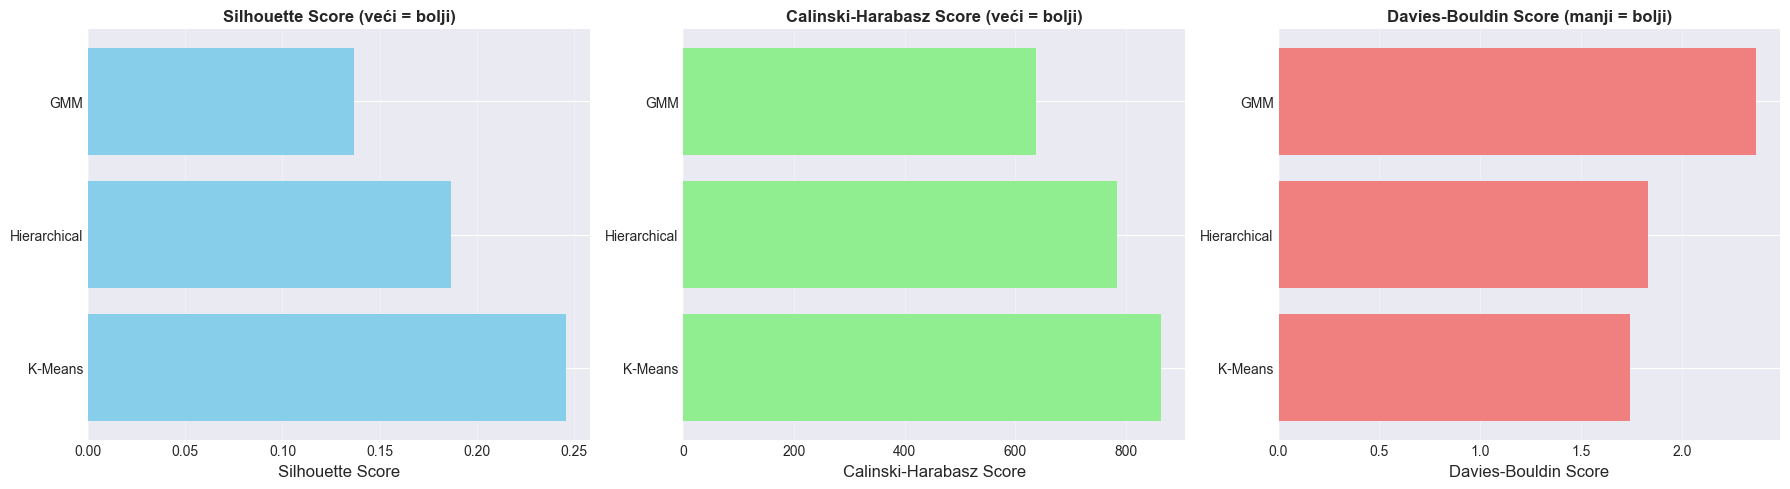


DETALJNA ANALIZA - NAJBOLJA METODA: K-Means

ANALIZA I PROFILISANJE KLASTERA

--- Veličina klastera ---
Cluster
0    929
1    274
2    453
3    381
Name: count, dtype: int64

Procenat uzoraka po klasterima:
Cluster
0    45.61
1    13.45
2    22.24
3    18.70
Name: count, dtype: float64

--- Prosečne vrednosti karakteristika po klasterima ---
           Age    Income  Total_Spent  Total_Purchases  NumWebPurchases  \
Cluster                                                                   
0        42.33  34166.02        78.34             5.44             1.89   
1        48.19  66430.02      1172.55            21.46             7.24   
2        48.22  52856.69       484.16            13.99             5.48   
3        46.68  72123.23      1164.06            18.81             4.82   

         NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
Cluster                                                              
0                       0.46               3.09               6.

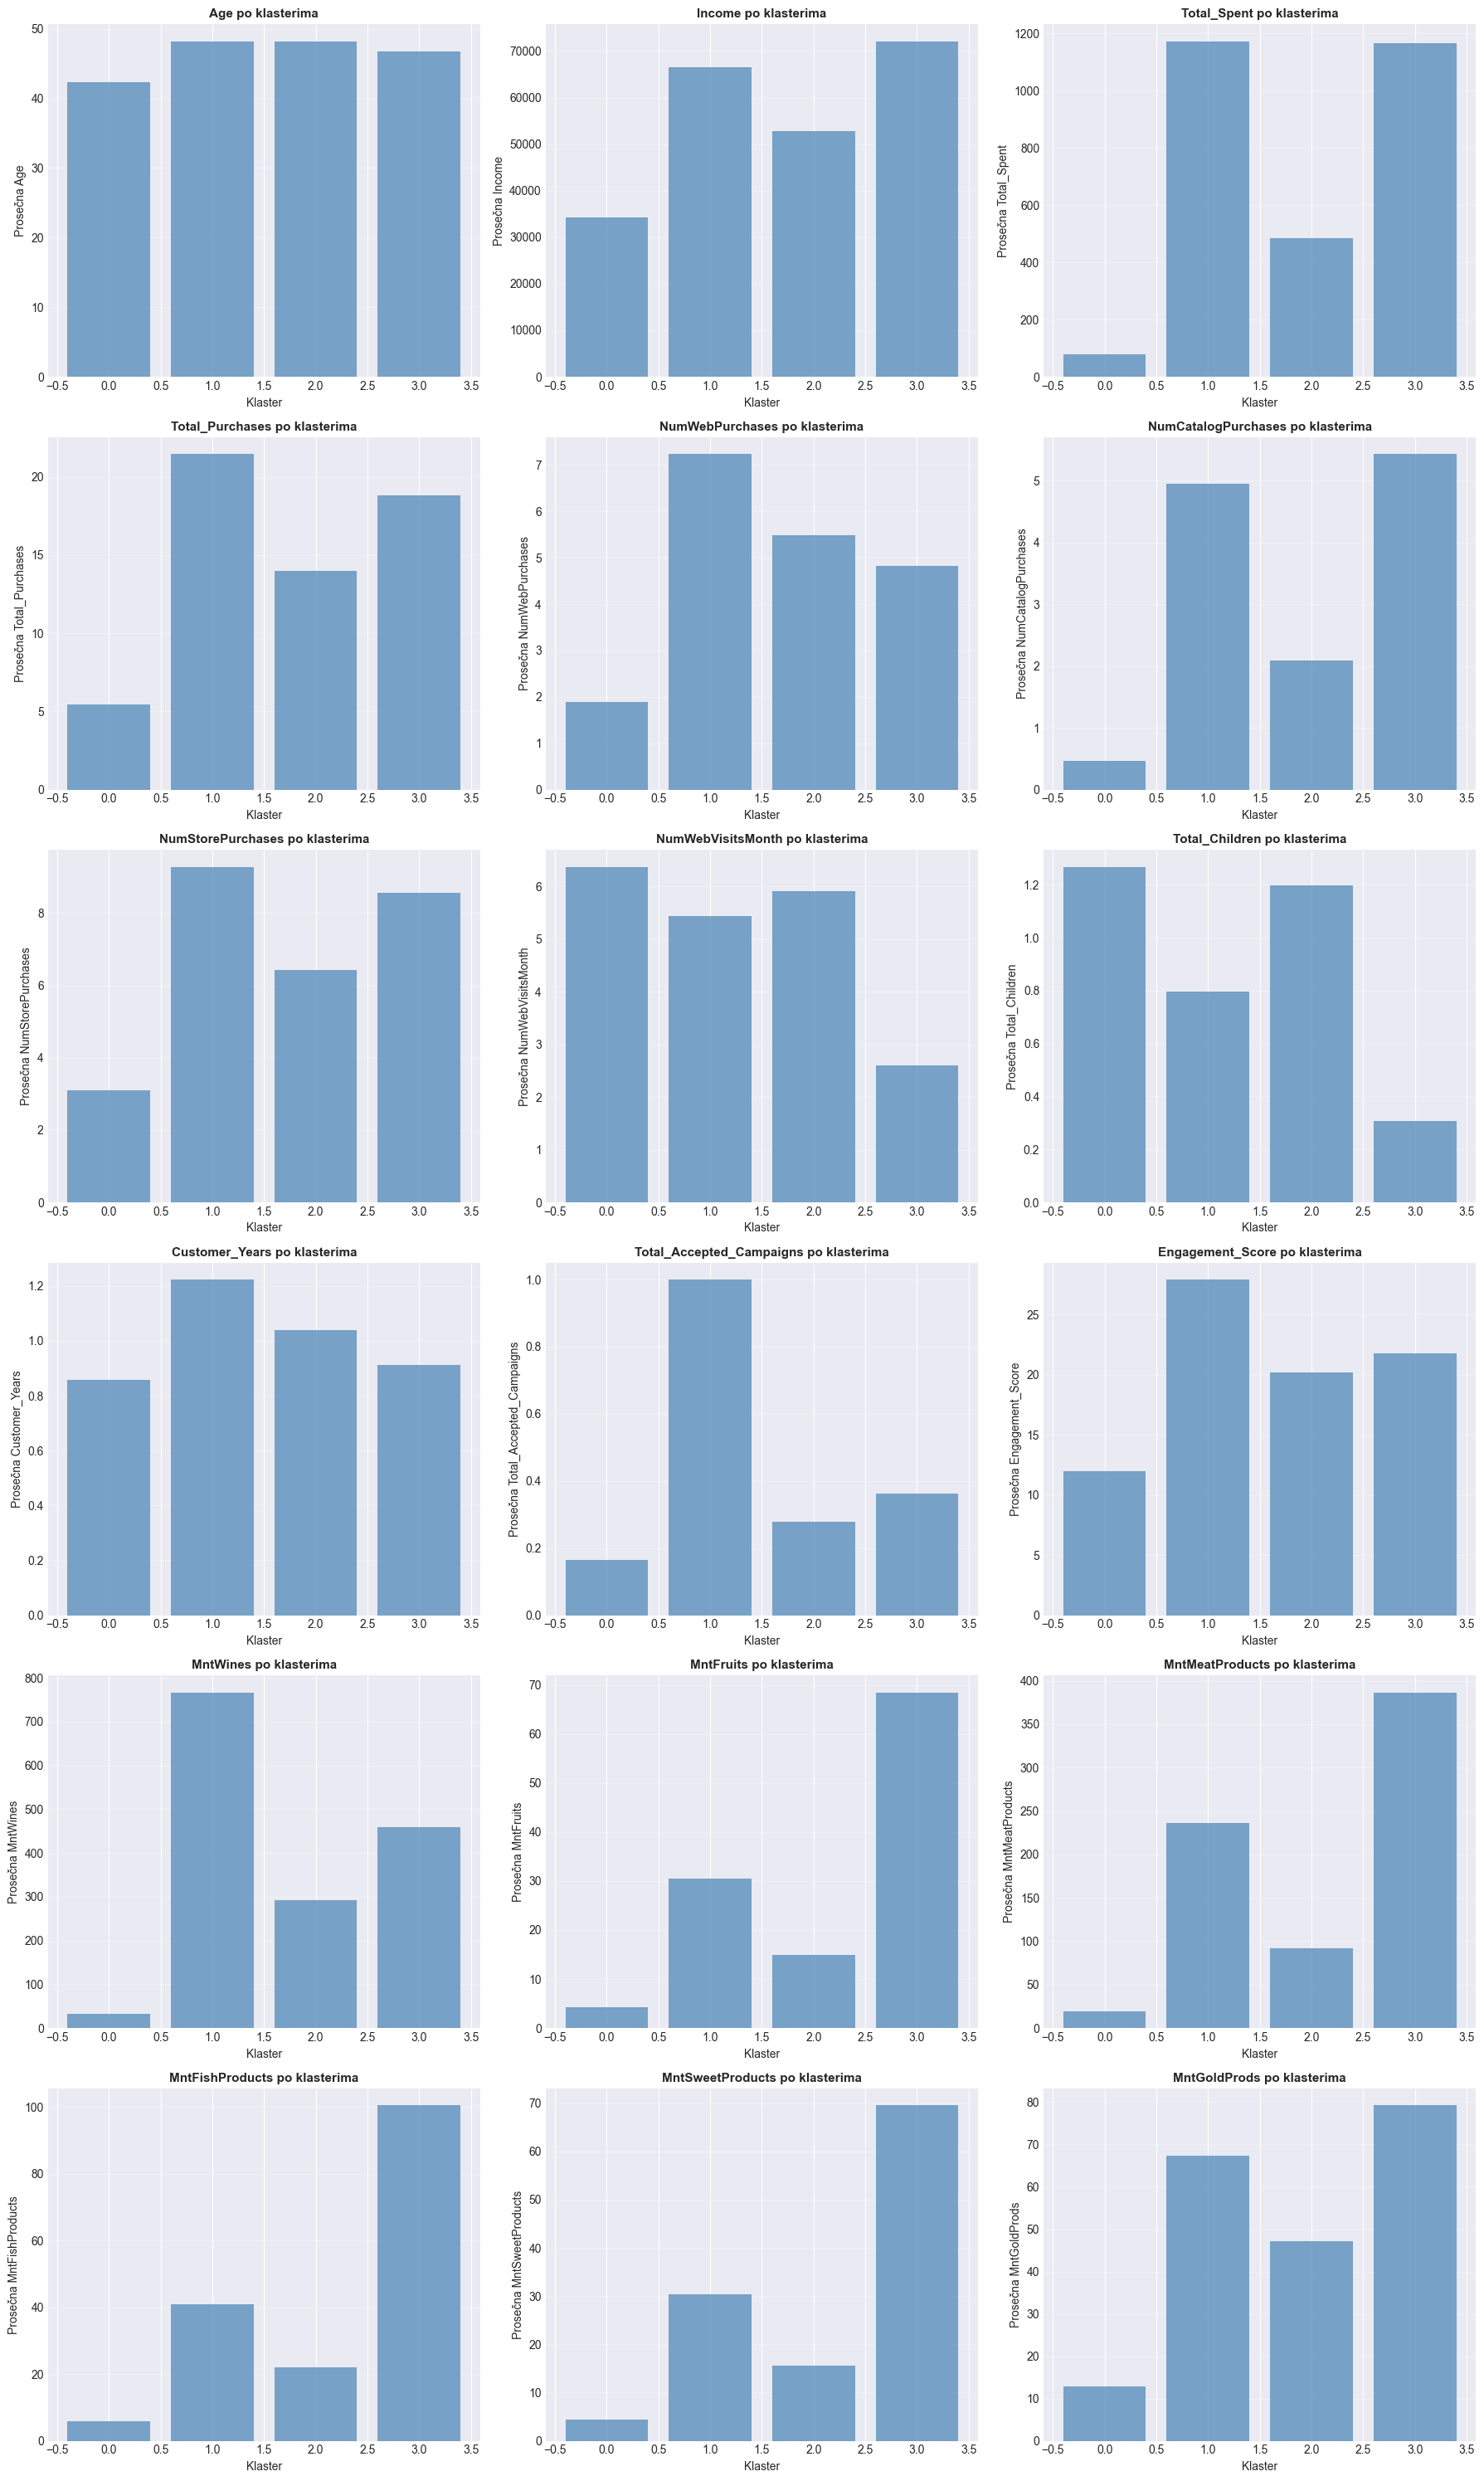


OPISNI PROFILI KLASTERA

KLASTER 0

Veličina: 929 kupaca (45.6% ukupnog)

Ključne karakteristike:
  - Income: 34166.02 (niža 31.3% od proseka)
  - Total_Spent: 78.34 (niža 84.9% od proseka)
  - Total_Purchases: 5.44 (niža 54.6% od proseka)
  - NumWebPurchases: 1.89 (niža 52.2% od proseka)
  - NumCatalogPurchases: 0.46 (niža 80.5% od proseka)
  - NumStorePurchases: 3.09 (niža 45.6% od proseka)
  - NumWebVisitsMonth: 6.37 (viša 17.2% od proseka)

KLASTER 1

Veličina: 274 kupaca (13.5% ukupnog)

Ključne karakteristike:
  - Income: 66430.02 (viša 33.5% od proseka)
  - Total_Spent: 1172.55 (viša 126.0% od proseka)
  - Total_Purchases: 21.46 (viša 78.9% od proseka)
  - NumWebPurchases: 7.24 (viša 82.9% od proseka)
  - NumCatalogPurchases: 4.95 (viša 109.9% od proseka)
  - NumStorePurchases: 9.28 (viša 63.2% od proseka)

KLASTER 2

Veličina: 453 kupaca (22.2% ukupnog)

Ključne karakteristike:
  - Total_Purchases: 13.99 (viša 16.6% od proseka)
  - NumWebPurchases: 5.48 (viša 38.5% od proseka)

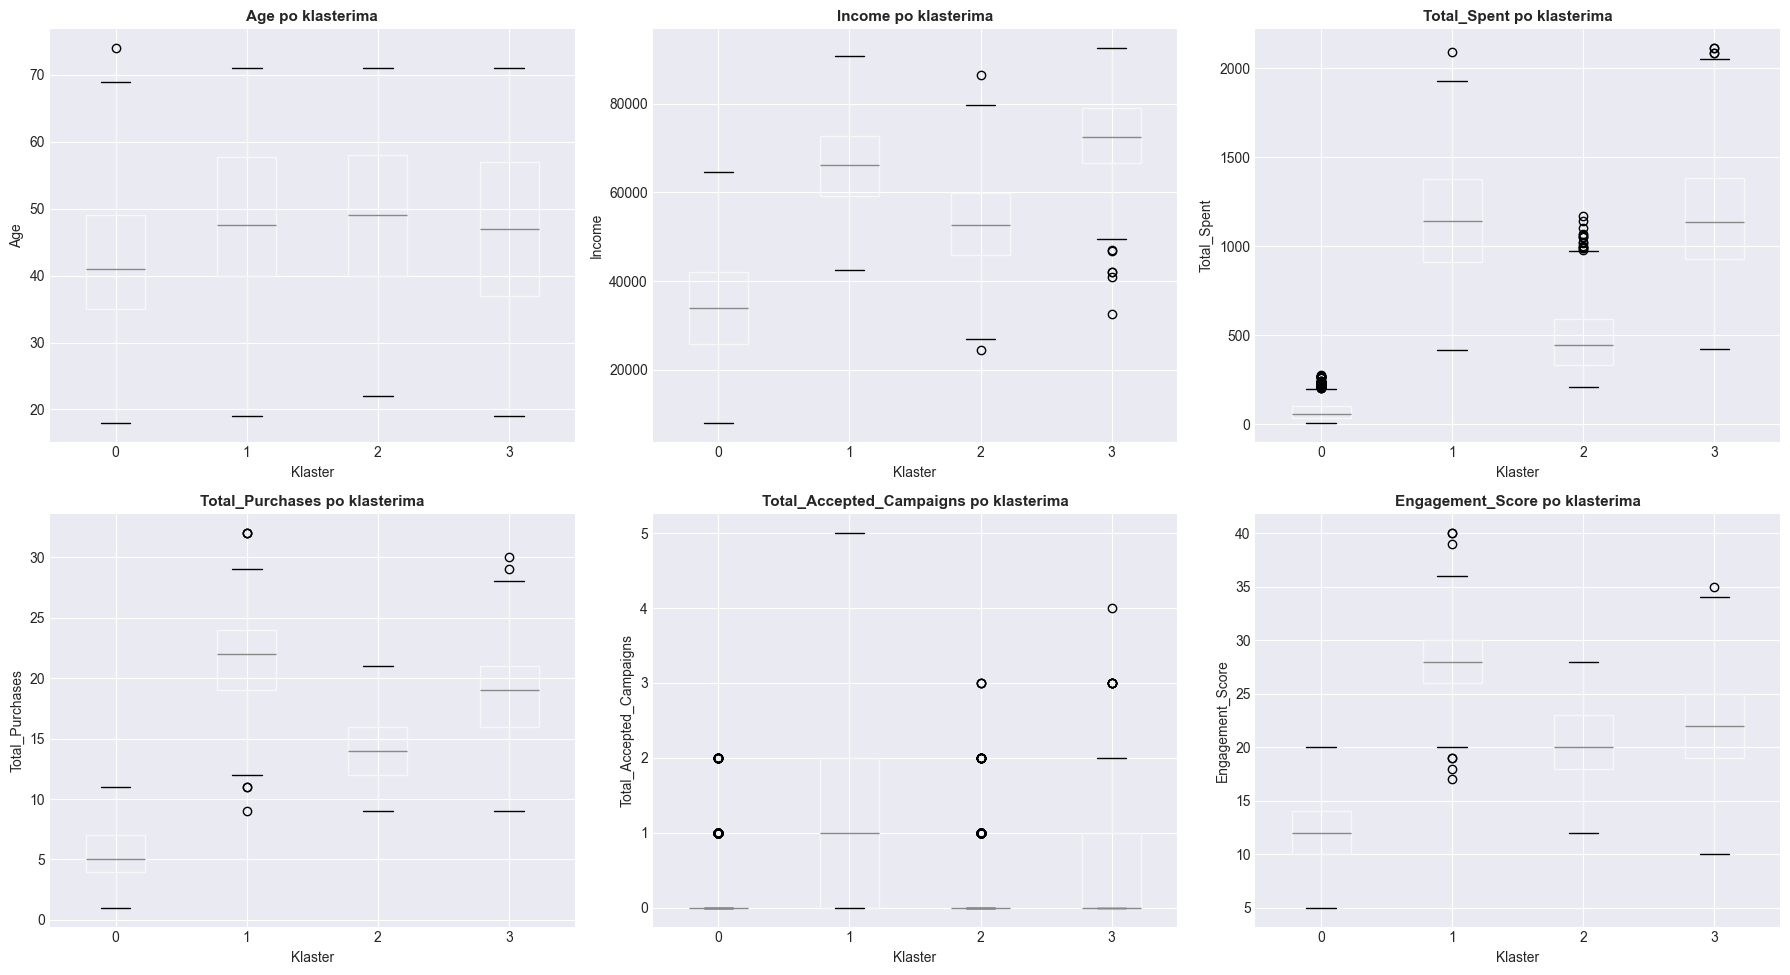


BUSINESS INSIGHTS I PREPORUKE

--- Klaster 0 ---
Prosečan prihod: $34,166
Prosečna potrošnja: $78
Prosečan broj prihvaćenih kampanja: 0.16
Prosečna starost: 42.3 godina

--- Klaster 1 ---
Prosečan prihod: $66,430
Prosečna potrošnja: $1,173
Prosečan broj prihvaćenih kampanja: 1.00
Prosečna starost: 48.2 godina
Preporuka: Premium kupci - fokusirajte se na loyalty programe i ekskluzivne ponude

--- Klaster 2 ---
Prosečan prihod: $52,857
Prosečna potrošnja: $484
Prosečan broj prihvaćenih kampanja: 0.28
Prosečna starost: 48.2 godina
Preporuka: Premium kupci - fokusirajte se na loyalty programe i ekskluzivne ponude

--- Klaster 3 ---
Prosečan prihod: $72,123
Prosečna potrošnja: $1,164
Prosečan broj prihvaćenih kampanja: 0.36
Prosečna starost: 46.7 godina
Preporuka: Premium kupci - fokusirajte se na loyalty programe i ekskluzivne ponude

REZIME PROJEKTA

Broj analiziranih kupaca: 2037
Broj korišćenih feature-a: 18
Broj PCA komponenti: 9
Najbolja metoda klasterizacije: K-Means
Broj identifiko

In [10]:
df_final, final_labels, profiles = main_pipeline()